In [35]:
import sys
sys.path.append('..')
sys.path.append('../..')

import os
import numpy as np
import pandas as pd
import nitools as nt
import matplotlib.pyplot as plt
import seaborn as sns

from pathlib import Path
from SUITPy import flatmap
import PcmPy as pcm
import scipy.stats as stats

import selective_recruitment.plotting as plotting
import selective_recruitment.globals as gl

import Functional_Fusion.dataset as fdata
import Functional_Fusion.atlas_map as am
from statsmodels.stats.anova import AnovaRM  # perform F test
from statsmodels.stats.multicomp import pairwise_tukeyhsd

from selective_recruitment.scripts.script_roi_differences import norm_within_category,prep_roi_comparison, plot_roi_differences

import warnings
warnings.filterwarnings('ignore')


wkdir = 'A:\data\Cerebellum\CerebellumWorkingMemory\selective_recruit'
if not Path(wkdir).exists():
    wkdir = '/srv/diedrichsen/data/Cerebellum/CerebellumWorkingMemory/selective_recruit'
if not Path(wkdir).exists():
    wkdir = '/Volumes/diedrichsen_data$/data/Cerebellum/CerebellumWorkingMemory/selective_recruit'    
if not Path(wkdir).exists():
    wkdir = '/Users/jdiedrichsen/Data/wm_cerebellum/selective_recruit'

# set up colors
colors = ['#FFC20A', # yellow
          '#0C7BDC', # blue
          ]
colors2 = ['#EF7F24', # orange 
           '#FA142B', # red
           '#7C30E1', # purple
           '#FFC20A', # yellow
           '#45C2EF', # light blue
           ]

seaborn_colors = ['#949494', # grey
                  '#BD926E', # brown
                  '#BA611B', # dark orange
                  '#C38820', # orange
                  '#F2B8E0', # pink
                  '#C283B5', # purple
                  '#158B6A', # green
                  '#176D9C', # blue
                  ]

seaborn_colors = [
                  '#176D9CFF', # blue
                  '#176D9C80', # blue
                  '#158B6AFF', # green
                  '#158B6A80', # green
                  '#FFC20AFF', # yellow
                  '#FFC20A80', # yellow
                  '#BA611BFF', # dark orange
                  '#BA611B80', # dark orange
                  ]

## Comparison of activity profiles within 4 quadrants of the multiple demand network.
Left - Right


Anterior - Posterior


In [36]:
df_path = os.path.join(wkdir, "wm_ROI_NettekovenSym68c32AP_conn_reg.tsv")
D = pd.read_csv(df_path, sep="\t")
D, cond_map = prep_roi_comparison(D)
norm = 'mean'
cats = ['sn']

In [37]:
D = norm_within_category(D, category=cats, value='Y', norm=norm)
D = D.loc[D.roi != 0]
D = D.loc[D.cond_name != "rest"]
D["AP"] = D["roi_name"].str[4]

# mapping values of phase column to strings: 0->'encoding', 1->'retrieve'
D['phase_str'] = D['phase'].map({0: 'encoding', 1: 'retrieve'})

# load effect
D_load = D[(D.load == 6) & (D.recall == 1)]
DL2 = D[(D.load == 2) & (D.recall == 1)]
D_load["YL"] = D_load.Y.values - DL2.Y.values
D_load = norm_within_category(D_load, category=cats, value='YL', norm=norm)


# recall effect
D_recall = D[(D.recall == 0)]
D_fw = D[(D.recall == 1)]
D_recall["YL"] = D_recall.Y.values - D_fw.Y.values
D_recall = norm_within_category(D_recall, category=cats, value='YL', norm=norm)

                   Anova
              F Value Num DF  Den DF Pr > F
-------------------------------------------
side          35.9043 1.0000 15.0000 0.0000
AP             1.7850 1.0000 15.0000 0.2015
phase          1.4822 1.0000 15.0000 0.2422
side:AP        5.2118 1.0000 15.0000 0.0374
side:phase     0.0921 1.0000 15.0000 0.7657
AP:phase      12.7940 1.0000 15.0000 0.0028
side:AP:phase  6.9591 1.0000 15.0000 0.0186

act > 0? encoding
TtestResult(statistic=4.593454488116407, pvalue=0.000351515847095903, df=15)
act > 0? retrieval
TtestResult(statistic=4.219774313481482, pvalue=0.0007426531605510383, df=15)


,group1,group2,meandiff,p-adj,lower,upper,reject
1,ALencoding,ARencoding,0.0251,0.0002,0.0080,0.0423,True
8,ALretrieve,ARretrieve,0.0180,0.0311,0.0009,0.0351,True
21,ARretrieve,PRretrieve,0.0435,0.0000,0.0264,0.0607,True
23,PLencoding,PRencoding,0.0404,0.0000,0.0233,0.0575,True
26,PLretrieve,PRretrieve,0.0510,0.0000,0.0339,0.0682,True


,group1,group2,meandiff,p-adj,lower,upper,reject
22,PLencoding,PLretrieve,0.0252,0.0002,0.0081,0.0423,True
27,PRencoding,PRretrieve,0.0358,0.0000,0.0187,0.0529,True


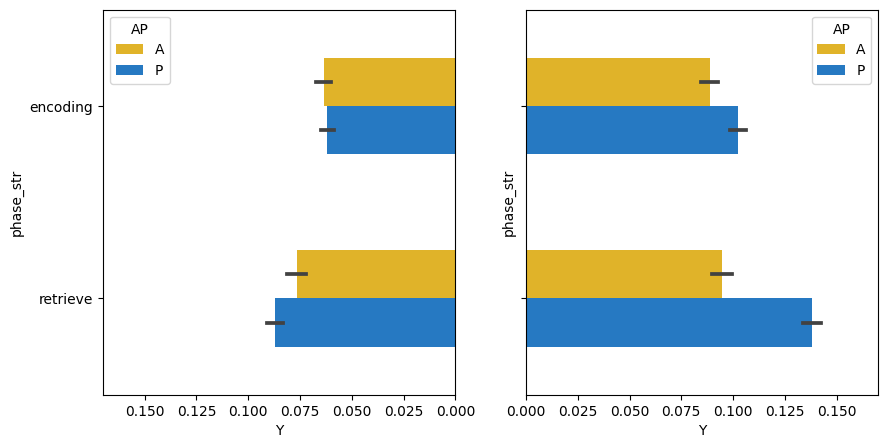

In [59]:
fig, axes = plt.subplots(figsize=(10,5), ncols=2, sharey=True)

sns.barplot(data = D.loc[D.side == "L"], x = "Y", width = 0.5, hue = D.AP, y = "phase_str", errorbar="se", units = "sn", palette = colors, ax = axes[0])
# set the limist of the x axis
axes[0].set_xlim([0, 0.17])
# invert the horizontal axis
axes[0].invert_xaxis()

sns.barplot(data = D.loc[D.side == "R"], x = "Y", width = 0.5, hue = D.AP, y = "phase_str", errorbar = "se", units = "sn", palette = colors, ax=axes[1])
# set the limist of the x axis
axes[1].set_xlim([0, 0.17])

# ax.set_xlim([-0.07, 0.07])
plt.savefig("topo_overall_barplot.pdf")

print(AnovaRM(data=D, depvar='Y',subject='sn', within=['side', 'AP', 'phase'], aggregate_func=np.mean).fit())

# is activation within the multiple demand network significant?
print("act > 0? encoding")
DD2 = D.groupby(["sn", "phase"]).mean().reset_index()
print(stats.ttest_rel(DD2[(DD2.phase == 0)].Y.values, np.zeros(len(DD2[(DD2.phase == 0)].Y.values))))

print("act > 0? retrieval")
DD2 = D.groupby(["sn", "phase"]).mean().reset_index()
print(stats.ttest_rel(DD2[(DD2.phase == 1)].Y.values, np.zeros(len(DD2[(DD2.phase == 1)].Y.values))))

# post hoc test
T = pairwise_tukeyhsd(D.Y.values, D.AP+D.side+D.phase_str, alpha=0.05)
Tdf = pd.DataFrame(T._results_table.data[1:])
Tdf.columns = T._results_table.data[0]
Tdf = Tdf[Tdf.reject == True]
idx = ((Tdf.group1.str[0] == Tdf.group2.str[0])^(Tdf.group1.str[1] == Tdf.group2.str[1])) & (Tdf.group1.str[2:] == Tdf.group2.str[2:])
A = Tdf.loc[idx]
display(A)


idx = ((Tdf.group1.str[0] == Tdf.group2.str[0])&(Tdf.group1.str[1] == Tdf.group2.str[1])) & (Tdf.group1.str[2:] != Tdf.group2.str[2:])
B = Tdf.loc[idx]
display(B)

                   Anova
              F Value Num DF  Den DF Pr > F
-------------------------------------------
side           0.8497 1.0000 15.0000 0.3712
AP             0.2507 1.0000 15.0000 0.6238
phase          3.2148 1.0000 15.0000 0.0932
side:AP        3.2918 1.0000 15.0000 0.0897
side:phase     2.4409 1.0000 15.0000 0.1391
AP:phase       0.6533 1.0000 15.0000 0.4316
side:AP:phase  0.0001 1.0000 15.0000 0.9907



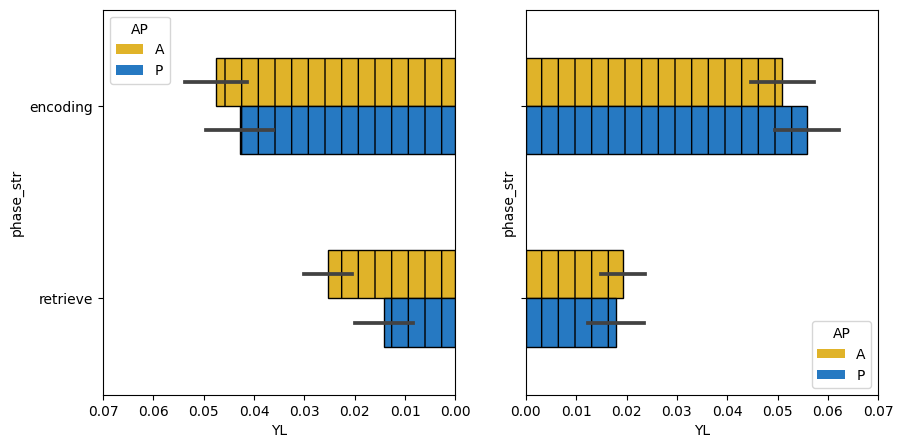

In [56]:
fig, axes = plt.subplots(figsize=(10,5), ncols=2, sharey=True)


ax = sns.barplot(data = D_load.loc[D_load.side == "L"], x = "YL", hue = D_load.AP, y = "phase_str", errorbar="se", units = "sn", palette = colors, width = 0.5, ax = axes[0])

# set the limist of the x axis
axes[0].set_xlim([0, 0.07])
# invert the horizontal axis
axes[0].invert_xaxis()

ax = sns.barplot(data = D_load.loc[D_load.side == "R"], x = "YL", hue = D_load.AP, y = "phase_str", errorbar="se", units = "sn", palette = colors, width = 0.5, ax = axes[1])
axes[1].set_xlim([0, 0.07])
# set the limist of the x axis
# axes[1].set_xlim([0, 0.17])
# Define some hatches
hatches = ['|', '|', '|', '|']

# Loop over the bars
for i,thisbar in enumerate(axes[0].patches):
    # Set a different hatch for each bar
    thisbar.set_hatch(hatches[i])
    thisbar.set_edgecolor('black')


# Loop over the bars
for i,thisbar in enumerate(axes[1].patches):
    # Set a different hatch for each bar
    thisbar.set_hatch(hatches[i])
    thisbar.set_edgecolor('black')

plt.savefig("topo_load_barplot.pdf")
print(AnovaRM(data=D_load[(D_load.cond_name != 'rest')], depvar='YL',subject='sn', within=['side', 'AP', 'phase'], aggregate_func=np.mean).fit())

                   Anova
              F Value Num DF  Den DF Pr > F
-------------------------------------------
side           6.8621 1.0000 15.0000 0.0193
AP             0.7841 1.0000 15.0000 0.3899
phase          0.0611 1.0000 15.0000 0.8081
side:AP        0.0430 1.0000 15.0000 0.8385
side:phase     1.1566 1.0000 15.0000 0.2992
AP:phase       1.0467 1.0000 15.0000 0.3225
side:AP:phase  0.0216 1.0000 15.0000 0.8851

TtestResult(statistic=2.6195696339780516, pvalue=0.01933050354661796, df=15)


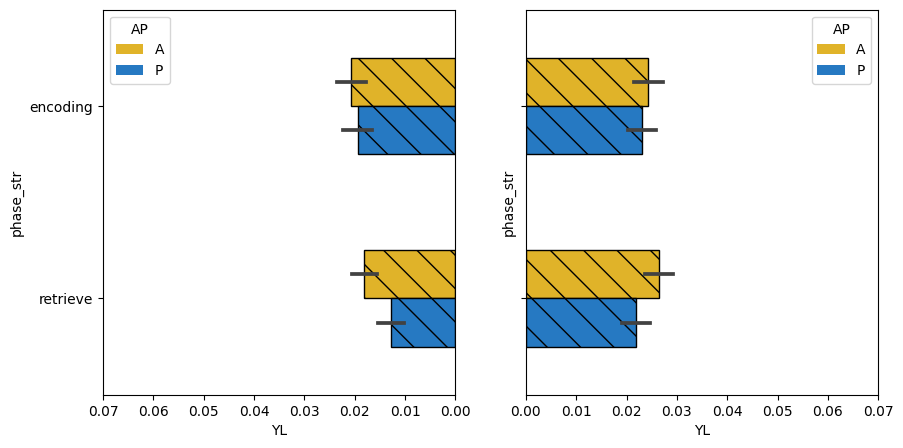

In [57]:
# ax = sns.barplot(data = D_recall.loc[D_recall.side == "L"], x = "phase", hue = D.side + D.AP,y = "Y_norm", errorbar="se", units = "sn", palette = "colorblind")
# ax.set_ylim(0, 0.03)
fig, axes = plt.subplots(figsize=(10,5), ncols=2, sharey=True)
ax = sns.barplot(data = D_recall.loc[D_recall.side == "L"], x = "YL", hue = D.AP, y = "phase_str", errorbar="se", units = "sn", palette = colors, width = 0.5, ax = axes[0])

# set the limist of the x axis
axes[0].set_xlim([0, 0.07])
# invert the horizontal axis
axes[0].invert_xaxis()

ax = sns.barplot(data = D_recall.loc[D_recall.side == "R"], x = "YL", hue = D.AP, y = "phase_str", errorbar="se", units = "sn", palette = colors, width = 0.5, ax = axes[1])
axes[1].set_xlim([0, 0.07])
print(AnovaRM(data=D_recall[(D_recall.cond_name != 'rest')], depvar='YL',subject='sn', within=['side', 'AP', 'phase'], aggregate_func=np.mean).fit())
# mean recall effect is significantly different between left and right hemispheres
# Define some hatches
hatches = ['\\', '\\', '\\', '\\']

# Loop over the bars
for i,thisbar in enumerate(axes[0].patches):
    # Set a different hatch for each bar
    thisbar.set_hatch(hatches[i])
    thisbar.set_edgecolor('black')
# Loop over the bars
for i,thisbar in enumerate(axes[1].patches):
    # Set a different hatch for each bar
    thisbar.set_hatch(hatches[i])
    thisbar.set_edgecolor('black')
    
plt.savefig("topo_recall_dir_barplot.pdf")

# post hoc tests
# left vs right: mean recall effect in the right hemisphere is significantly larger than in the left hemisphere
DD_recall = D_recall.groupby(["sn", "side"]).mean().reset_index()
print(stats.ttest_rel(DD_recall[(DD_recall.side == "R")].YL.values, DD_recall[(DD_recall.side == "L")].YL.values))


## Comparison of activity profiles within sub-regions of the multiple demand network
Left - Right

D1 - D2 - D3 - D4

In [49]:
df_path = os.path.join(wkdir, "wm_ROI_NettekovenSym68c32_conn_reg.tsv")
D2 = pd.read_csv(df_path, sep="\t")
D2, cond_map = prep_roi_comparison(D2)
norm = 'mean'
cats = ['sn']

D2 = norm_within_category(D2, category=cats, value='Y', norm=norm)
D2 = D2.loc[D2.roi != 0]
D2 = D2.loc[D2.cond_name != "rest"]

# mapping values of phase column to strings: 0->'encoding', 1->'retrieve'
D2['phase_str'] = D2['phase'].map({0: 'encoding', 1: 'retrieve'})

# load effect
D2_load = D2[(D2.load == 6) & (D2.recall == 1)]
DL2 = D2[(D2.load == 2) & (D2.recall == 1)]
D2_load["YL"] = D2_load.Y.values - DL2.Y.values
D2_load = norm_within_category(D2_load, category=cats, value='YL', norm=norm)


# recall effect
D2_recall = D2[(D2.recall == 0)]
D2_fw = D2[(D2.recall == 1)]
D2_recall["YL"] = D2_recall.Y.values - D2_fw.Y.values
D2_recall = norm_within_category(D2_recall, category=cats, value='YL', norm=norm)

# change colors
seaborn_colors = [
                  '#45C2EFFF', # light blue
                  '#158B6AFF', # green
                  '#C283B5FF', # purple
                  '#BA611BFF', # dark orange
                  ]

                  Anova
             F Value Num DF  Den DF Pr > F
------------------------------------------
side         47.9171 1.0000 15.0000 0.0000
roi_sub      36.6061 3.0000 45.0000 0.0000
side:roi_sub  6.8727 3.0000 45.0000 0.0007

TtestResult(statistic=7.286486117923188, pvalue=2.667747346548626e-06, df=15)


,group1,group2,meandiff,p-adj,lower,upper,reject
0,L1,L2,-0.0396,0.0000,-0.0606,-0.0186,True
7,L2,L3,0.0585,0.0000,0.0375,0.0795,True
8,L2,L4,0.0225,0.0255,0.0015,0.0435,True
13,L3,L4,-0.0360,0.0000,-0.0570,-0.0150,True
22,R1,R2,-0.0655,0.0000,-0.0865,-0.0445,True
23,R1,R3,0.0277,0.0017,0.0067,0.0487,True
24,R1,R4,-0.0349,0.0000,-0.0559,-0.0139,True
25,R2,R3,0.0932,0.0000,0.0722,0.1142,True
26,R2,R4,0.0306,0.0003,0.0096,0.0516,True
27,R3,R4,-0.0626,0.0000,-0.0836,-0.0416,True


,group1,group2,meandiff,p-adj,lower,upper,reject
3,L1,R1,0.0415,0.0000,0.0205,0.0625,True
16,L3,R3,0.0503,0.0000,0.0293,0.0713,True
21,L4,R4,0.0237,0.0146,0.0027,0.0447,True


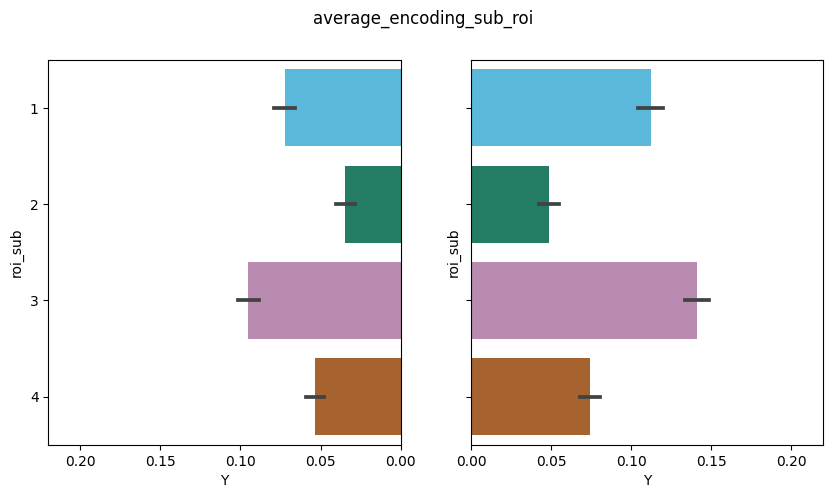

In [50]:
# during encoding
fig, axes = plt.subplots(figsize=(10,5), ncols=2, sharey=True)
ax = sns.barplot(data = D2.loc[D2.phase == 0].loc[D2.side == "L"], width = 0.8, x = "Y",hue_order=["roi_sub"], y = D2.roi_sub, errorbar="se", units = "sn", palette = seaborn_colors, ax = axes[0])

# set the limist of the x axis
axes[0].set_xlim([0, 0.22])
# invert the horizontal axis
axes[0].invert_xaxis()

ax = sns.barplot(data = D2.loc[D2.phase == 0].loc[D2.side == "R"], width = 0.8, x = "Y", hue_order=["roi_sub"], y = D2.roi_sub, errorbar="se", units = "sn", palette = seaborn_colors, ax = axes[1])
axes[1].set_xlim([0, 0.22])
fig.suptitle("average_encoding_sub_roi")
plt.savefig("topo_average_sub_enc_barplot.pdf")

print(AnovaRM(data=D2.loc[D2.phase == 0], depvar='Y',subject='sn', within=['side', 'roi_sub'], aggregate_func=np.mean).fit())



# post hoc tests
DD = D.groupby(["sn", "side", "phase"]).mean().reset_index()
print(stats.ttest_rel(DD.loc[(DD.phase == 0)&(DD.side == "R")].Y.values, DD.loc[(DD.phase == 0)&(DD.side == "L")].Y.values))

D_phase = D.loc[D.phase == 0]
T = pairwise_tukeyhsd(D_phase.Y.values, D_phase.side+D_phase.roi_sub, alpha=0.05)
Tdf = pd.DataFrame(T._results_table.data[1:])
Tdf.columns = T._results_table.data[0]
Tdf

Tdf = Tdf[Tdf.reject == True]
idx = ((Tdf.group1.str[0] == Tdf.group2.str[0])&(Tdf.group1.str[1] != Tdf.group2.str[1]))
A = Tdf.loc[idx]
display(A)

Tdf = Tdf[Tdf.reject == True]
idx = ((Tdf.group1.str[0] != Tdf.group2.str[0])&(Tdf.group1.str[1] == Tdf.group2.str[1]))
B = Tdf.loc[idx]
display(B)

                  Anova
             F Value Num DF  Den DF Pr > F
------------------------------------------
side         19.4911 1.0000 15.0000 0.0005
roi_sub      44.2320 3.0000 45.0000 0.0000
side:roi_sub  4.9469 3.0000 45.0000 0.0047



,group1,group2,meandiff,p-adj,lower,upper,reject
0,L1,L2,-0.0369,0.0002,-0.0621,-0.0118,True
1,L1,L3,0.0545,0.0000,0.0293,0.0797,True
3,L1,R1,0.0530,0.0000,0.0279,0.0782,True
7,L2,L3,0.0914,0.0000,0.0663,0.1166,True
8,L2,L4,0.0436,0.0000,0.0184,0.0687,True
13,L3,L4,-0.0478,0.0000,-0.0730,-0.0227,True
16,L3,R3,0.0455,0.0000,0.0203,0.0707,True
21,L4,R4,0.0269,0.0263,0.0017,0.0520,True
22,R1,R2,-0.0773,0.0000,-0.1024,-0.0521,True
23,R1,R3,0.0470,0.0000,0.0218,0.0721,True


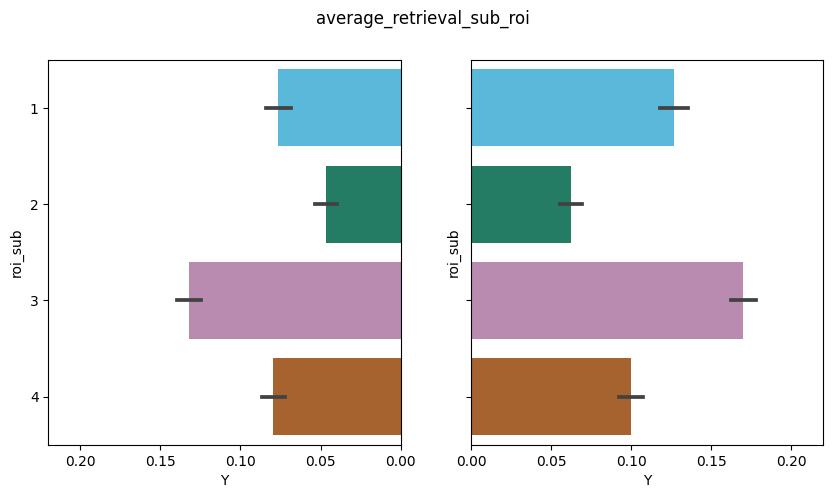

In [43]:
# during retreival
fig, axes = plt.subplots(figsize=(10,5), ncols=2, sharey=True)
ax = sns.barplot(data = D2.loc[D2.phase == 1].loc[D2.side == "L"], width = 0.8, x = "Y",hue_order=["roi_sub"], y = D2.roi_sub, errorbar="se", units = "sn", palette = seaborn_colors, ax = axes[0])

# set the limist of the x axis
axes[0].set_xlim([0, 0.22])
# invert the horizontal axis
axes[0].invert_xaxis()

ax = sns.barplot(data = D2.loc[D2.phase == 1].loc[D2.side == "R"], width = 0.8, x = "Y", hue_order=["roi_sub"], y = D2.roi_sub, errorbar="se", units = "sn", palette = seaborn_colors, ax = axes[1])
axes[1].set_xlim([0, 0.22])
fig.suptitle("average_retrieval_sub_roi")

plt.savefig("topo_average_sub_ret_barplot.pdf")

# sns.barplot(data = D.loc[D.phase == 1], x = "roi_sub", hue = D.side + D.AP, y = "Y", ci = 70, units = "sn", palette = "colorblind")
print(AnovaRM(data=D2.loc[D2.phase == 1], depvar='Y',subject='sn', within=['side', 'roi_sub'], aggregate_func=np.mean).fit())

# post hoc test
D_phase = D.loc[D.phase == 1]
T = pairwise_tukeyhsd(D_phase.Y.values, D_phase.side+D_phase.roi_sub, alpha=0.05)
Tdf = pd.DataFrame(T._results_table.data[1:])
Tdf.columns = T._results_table.data[0]
Tdf

Tdf = Tdf[Tdf.reject == True]
idx = ((Tdf.group1.str[0] == Tdf.group2.str[0])^(Tdf.group1.str[1] == Tdf.group2.str[1]))
A = Tdf.loc[idx]
display(A)

                  Anova
             F Value Num DF  Den DF Pr > F
------------------------------------------
side          1.7864 1.0000 15.0000 0.2013
roi_sub       8.6312 3.0000 45.0000 0.0001
side:roi_sub  1.2572 3.0000 45.0000 0.3004

                  Anova
             F Value Num DF  Den DF Pr > F
------------------------------------------
side          0.5965 1.0000 15.0000 0.4519
roi_sub      16.7107 3.0000 45.0000 0.0000
side:roi_sub  1.5437 3.0000 45.0000 0.2162



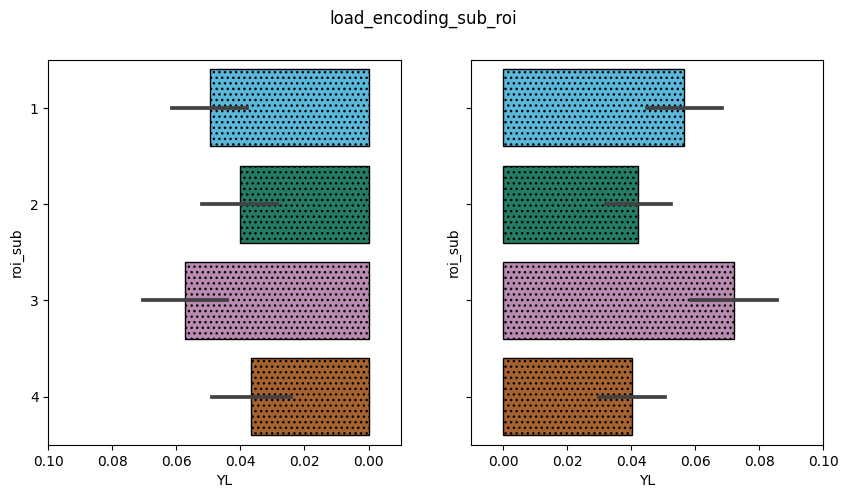

In [44]:
# during encoding
fig, axes = plt.subplots(figsize=(10,5), ncols=2, sharey=True)
ax = sns.barplot(data = D2_load.loc[D2_load.phase == 0].loc[D2_load.side == "L"], width = 0.8, x = "YL",hue_order=["roi_sub"], y = D2_load.roi_sub, errorbar="se", units = "sn", palette = seaborn_colors, ax = axes[0])

# set the limist of the x axis
axes[0].set_xlim([-0.01, 0.1])
# invert the horizontal axis
axes[0].invert_xaxis()

ax = sns.barplot(data = D2_load.loc[D2_load.phase == 0].loc[D2_load.side == "R"], width = 0.8, x = "YL", hue_order=["roi_sub"], y = D2_load.roi_sub, errorbar="se", units = "sn", palette = seaborn_colors, ax = axes[1])
axes[1].set_xlim([-0.01, 0.1])
fig.suptitle("load_encoding_sub_roi")

# Define some hatches
hatches = ['|', '|', '|', '|', '|', '|', '|', '|']

# Loop over the bars
for i,thisbar in enumerate(axes[0].patches):
    # Set a different hatch for each bar
    thisbar.set_hatch(hatches[i])
    thisbar.set_edgecolor('black')


# Loop over the bars
for i,thisbar in enumerate(axes[1].patches):
    # Set a different hatch for each bar
    thisbar.set_hatch(hatches[i])
    thisbar.set_edgecolor('black')

plt.savefig("topo_load_sub_enc_barplot.pdf")

# sns.barplot(data = D.loc[D.phase == 1], x = "roi_sub", hue = D.side + D.AP, y = "Y", ci = 70, units = "sn", palette = "colorblind")
print(AnovaRM(data=D2_load.loc[D2_load.phase == 0], depvar='YL',subject='sn', within=['side', 'roi_sub'], aggregate_func=np.mean).fit())

# results for average across phases
print(AnovaRM(data=D2_load, depvar='YL',subject='sn', within=['side', 'roi_sub'], aggregate_func=np.mean).fit())
# D_phase = D_load.loc[D_load.phase == 0]
# T = pairwise_tukeyhsd(D_phase.Y.values, D_phase.roi_sub, alpha=0.05)
# Tdf = pd.DataFrame(T._results_table.data[1:])
# Tdf.columns = T._results_table.data[0]

# Tdf = Tdf[Tdf.reject == True]
# Tdf

                  Anova
             F Value Num DF  Den DF Pr > F
------------------------------------------
side          0.0840 1.0000 15.0000 0.7759
roi_sub      16.8586 3.0000 45.0000 0.0000
side:roi_sub  0.7002 3.0000 45.0000 0.5569



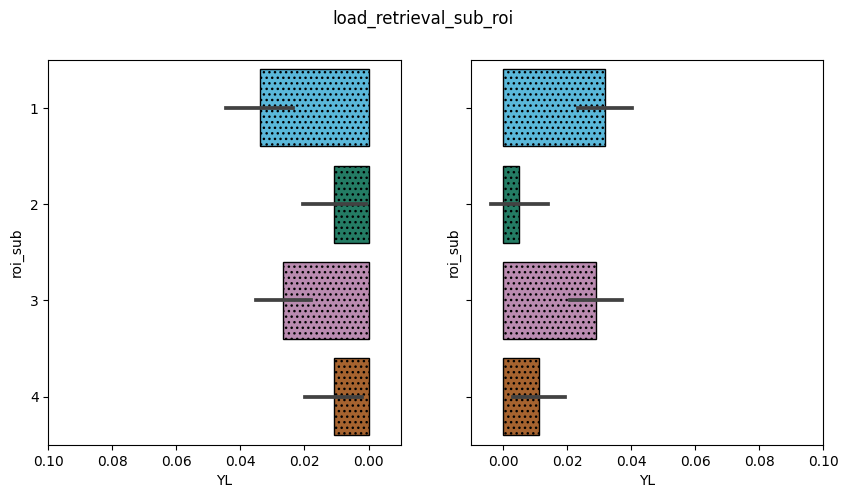

In [45]:
# during retrieval
fig, axes = plt.subplots(figsize=(10,5), ncols=2, sharey=True)
ax = sns.barplot(data = D2_load.loc[D2_load.phase ==1].loc[D2_load.side == "L"], width = 0.8, x = "YL",hue_order=["roi_sub"], y = D2_load.roi_sub, errorbar="se", units = "sn", palette = seaborn_colors, ax = axes[0])

# set the limist of the x axis
axes[0].set_xlim([-0.01, 0.1])
# invert the horizontal axis
axes[0].invert_xaxis()

ax = sns.barplot(data = D2_load.loc[D2_load.phase == 1].loc[D2_load.side == "R"], width = 0.8, x = "YL", hue_order=["roi_sub"], y = D2_load.roi_sub, errorbar="se", units = "sn", palette = seaborn_colors, ax = axes[1])
axes[1].set_xlim([-0.01, 0.1])
fig.suptitle("load_retrieval_sub_roi")

# Define some hatches
hatches = ['\\', '\\', '\\', '\\', '\\', '\\', '\\', '\\']

# Loop over the bars
for i,thisbar in enumerate(axes[0].patches):
    # Set a different hatch for each bar
    thisbar.set_hatch(hatches[i])
    thisbar.set_edgecolor('black')


# Loop over the bars
for i,thisbar in enumerate(axes[1].patches):
    # Set a different hatch for each bar
    thisbar.set_hatch(hatches[i])
    thisbar.set_edgecolor('black')

plt.savefig("topo_load_sub_ret_barplot.pdf")

# sns.barplot(data = D.loc[D.phase == 1], x = "roi_sub", hue = D.side + D.AP, y = "Y", ci = 70, units = "sn", palette = "colorblind")
print(AnovaRM(data=D2_load.loc[D2_load.phase == 1], depvar='YL',subject='sn', within=['side', 'roi_sub'], aggregate_func=np.mean).fit())

# D_phase = D_load.loc[D_load.phase == 1]
# T = pairwise_tukeyhsd(D_phase.Y.values, D_phase.roi_sub, alpha=0.05)
# Tdf = pd.DataFrame(T._results_table.data[1:])
# Tdf.columns = T._results_table.data[0]

# Tdf = Tdf[Tdf.reject == True]
# Tdf


                  Anova
             F Value Num DF  Den DF Pr > F
------------------------------------------
side          1.2862 1.0000 15.0000 0.2745
roi_sub       1.8253 3.0000 45.0000 0.1561
side:roi_sub  1.5700 3.0000 45.0000 0.2098



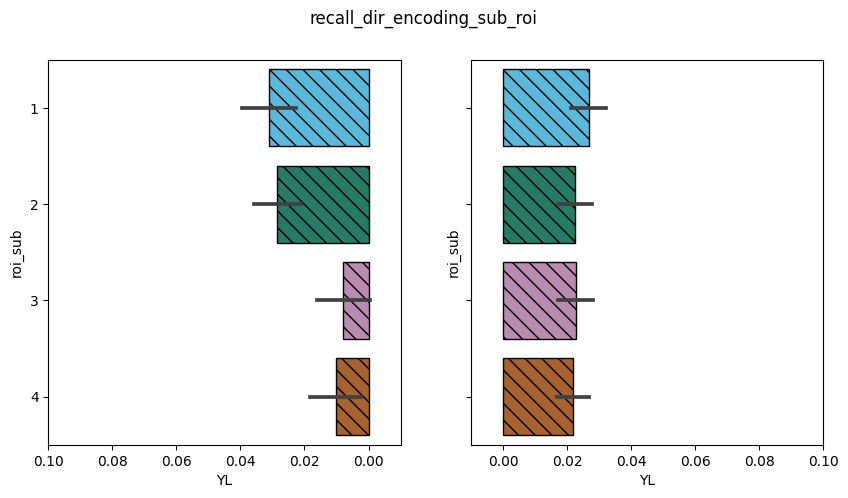

In [46]:
# during encoding
fig, axes = plt.subplots(figsize=(10,5), ncols=2, sharey=True)
ax = sns.barplot(data = D2_recall.loc[D2_recall.phase == 0].loc[D2_recall.side == "L"], width = 0.8, x = "YL",hue_order=["roi_sub"], y = D_recall.roi_sub, errorbar="se", units = "sn", palette = seaborn_colors, ax = axes[0])

# set the limist of the x axis
axes[0].set_xlim([-0.01, 0.1])
# invert the horizontal axis
axes[0].invert_xaxis()

ax = sns.barplot(data = D2_recall.loc[D2_recall.phase == 0].loc[D2_recall.side == "R"], width = 0.8, x = "YL", hue_order=["roi_sub"], y = D2_recall.roi_sub, errorbar="se", units = "sn", palette = seaborn_colors, ax = axes[1])
axes[1].set_xlim([-0.01, 0.1])
fig.suptitle("recall_dir_encoding_sub_roi")

# Define some hatches
hatches = ['\\\\', '\\\\', '\\\\', '\\\\', '\\\\', '\\\\', '\\\\', '\\\\']

# Loop over the bars
for i,thisbar in enumerate(axes[0].patches):
    # Set a different hatch for each bar
    thisbar.set_hatch(hatches[i])
    thisbar.set_edgecolor('black')


# Loop over the bars
for i,thisbar in enumerate(axes[1].patches):
    # Set a different hatch for each bar
    thisbar.set_hatch(hatches[i])
    thisbar.set_edgecolor('black')
    
plt.savefig("topo_recall_dir_sub_enc_barplot.pdf")

print(AnovaRM(data=D2_recall.loc[D2_recall.phase == 0], depvar='YL',subject='sn', within=['side', 'roi_sub'], aggregate_func=np.mean).fit())

                  Anova
             F Value Num DF  Den DF Pr > F
------------------------------------------
side          5.3687 1.0000 15.0000 0.0350
roi_sub      11.2487 3.0000 45.0000 0.0000
side:roi_sub  0.5359 3.0000 45.0000 0.6601



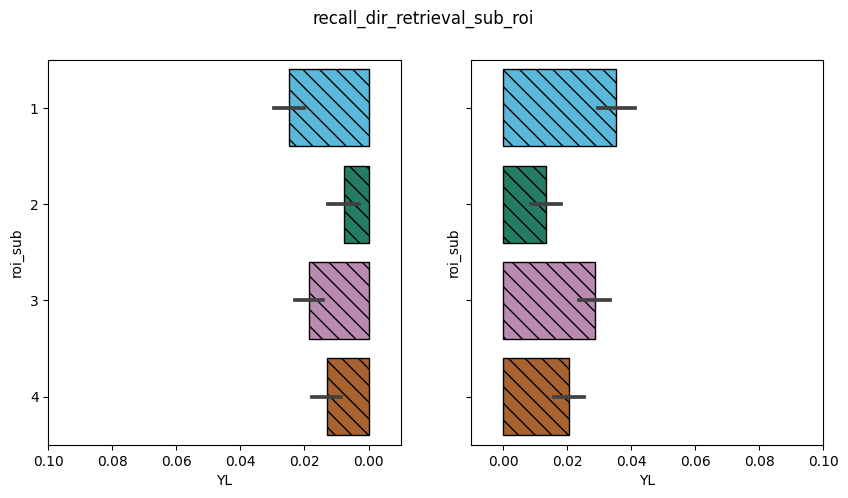

In [47]:
# during encoding
fig, axes = plt.subplots(figsize=(10,5), ncols=2, sharey=True)
ax = sns.barplot(data = D2_recall.loc[D2_recall.phase == 1].loc[D2_recall.side == "L"], width = 0.8, x = "YL",hue_order=["roi_sub"], y = D2_recall.roi_sub, errorbar="se", units = "sn", palette = seaborn_colors, ax = axes[0])

# set the limist of the x axis
axes[0].set_xlim([-0.01, 0.1])
# invert the horizontal axis
axes[0].invert_xaxis()

ax = sns.barplot(data = D2_recall.loc[D2_recall.phase == 1].loc[D2_recall.side == "R"], width = 0.8, x = "YL", hue_order=["roi_sub"], y = D2_recall.roi_sub, errorbar="se", units = "sn", palette = seaborn_colors, ax = axes[1])
axes[1].set_xlim([-0.01, 0.1])
fig.suptitle("recall_dir_retrieval_sub_roi")

# Define some hatches
hatches = ['\\\\', '\\\\', '\\\\', '\\\\', '\\\\', '\\\\', '\\\\', '\\\\']

# Loop over the bars
for i,thisbar in enumerate(axes[0].patches):
    # Set a different hatch for each bar
    thisbar.set_hatch(hatches[i])
    thisbar.set_edgecolor('black')


# Loop over the bars
for i,thisbar in enumerate(axes[1].patches):
    # Set a different hatch for each bar
    thisbar.set_hatch(hatches[i])
    thisbar.set_edgecolor('black')

plt.savefig("topo_recall_dir_sub_ret_barplot.pdf")

# sns.barplot(data = D.loc[D.phase == 1], x = "roi_sub", hue = D.side + D.AP, y = "Y", ci = 70, units = "sn", palette = "colorblind")
print(AnovaRM(data=D2_recall.loc[D2_recall.phase == 1], depvar='YL',subject='sn', within=['side', 'roi_sub'], aggregate_func=np.mean).fit())

# DD_recall = D2_recall.groupby(["sn", "roi_sub", "phase"]).mean().reset_index()

# D_phase = D_recall.loc[D_recall.phase == 1]
# T = pairwise_tukeyhsd(D_phase.Y.values, D_phase.roi_sub, alpha=0.05)
# Tdf = pd.DataFrame(T._results_table.data[1:])
# Tdf.columns = T._results_table.data[0]


# Tdf = Tdf[Tdf.reject == True]
# Tdf

